## 1. Parallel node execution

This module will build on human-in-the-loop as well as the memory concepts discussed in module 2.

We will dive into multi-agent workflows, and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

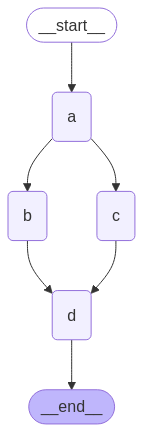

In [2]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

# this class act as state of the current graph
class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

# this class make a default node with given node secret
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# build the parallel graph
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

# display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


#### ! If we use fan out we must ensure the reducer is operator.add

When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key.

As we touched on in Module 2, operator.add is a function from Python's built-in operator module.

When operator.add is applied to lists, it performs list concatenation.

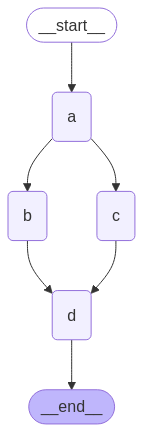

In [ ]:
import operator
from typing import Annotated

# makr the graph with new operator.add method
class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

#### ! Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

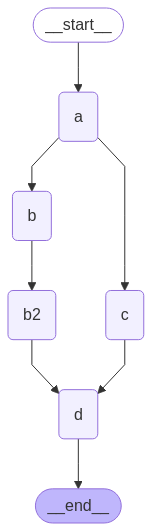

In [6]:
# in fan in way in node is wait until the other nodes are finished their executions
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# invoke the graph using sample empty state
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## 2. Working with LLMs
Now, lets add a realistic example!

We want to gather context from two external sources (Wikipedia and Web-Seach) and have an LLM answer a question.

In [8]:
# this is simple graph state
# context contain the external source result to a specific questions
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [11]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

## 3. Sub-graphs

Sub-graphs allow you to create and manage different states in different parts of your graph.

This is particularly useful for multi-agent systems, with teams of agents that each have their own state.

Let's consider a toy example:

- I have a system that accepts logs
- It performs two separate sub-tasks by different agents (summarize logs, find failure modes)
- I want to perform these two operations in two different sub-graphs.
- The most critical thing to understand is how the graphs communicate!

###  In short, communication is done with over-lapping keys:

- The sub-graphs can access docs from the parent
- The parent can access summary/failure_report from the sub-graphs


In [ ]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
# In the graph logs are passed as this structure
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

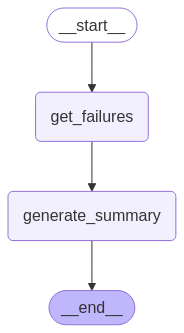

In [ ]:
# this is the graph use the logs and get the failures and make a summary
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph State
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(FailureAnalysisState,output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

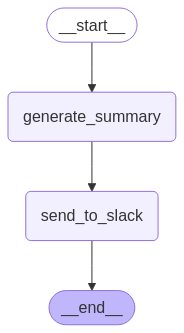

In [3]:
# This sub graph summarize the questions
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log] # this get from the main graph state so name is same
    qs_summary: str # this is internal state summary of question that question goes to generate a report
    report: str # this is report this use in the main graph
    processed_logs: List[str] # this is get from the main graph

# output state of the question summarization
class QuestionSummarizationOutputState(TypedDict):
    report: str # 
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
# total state of the graph
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

But, why does cleaned_logs have a reducer if it only goes into each sub-graph as an input? It is not modified.

cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs

- This is because the output state of the subgraphs will contain all keys, even if they are unmodified.

- The sub-graphs are run in parallel.

#### They are returned through the graph and only output the relevant states cleaned_logs: List[Log] , failures: List[Log], fa_summary: str, processed_logs: List[str]. So we need to add reducer like add.

Because the parallel sub-graphs return the same key, it needs to have a reducer like operator.add to combine the incoming values from each sub-graph.

But, we can work around this by using another concept we talked about before.

We can simply create an output state schema for each sub-graph and ensure that the output state schema contains different keys to publish as output.

We don't actually need each sub-graph to output cleaned_logs.

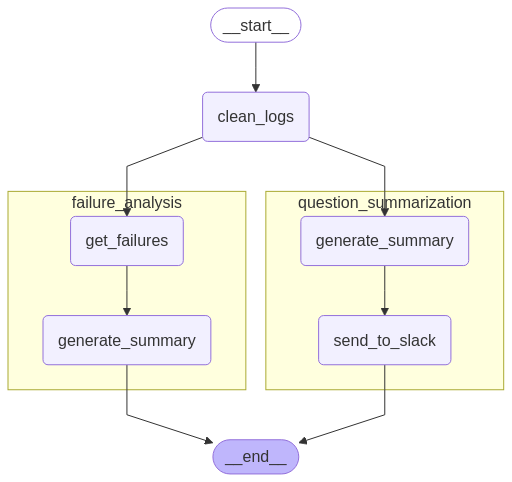

In [5]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

## 4. Map-reduce

it has two phases:

(1) Map - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) Reduce - Aggregate the results across all of the completed, parallelized sub-tasks.

In [1]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [2]:
# initialize llm chat model
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [3]:
# prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

### Parallelizing joke generation
First, let's define the entry point of the graph that will:

Take a user input topic
Produce a list of joke topics from it
Send each joke topic to our above joke generation node
Our state has a jokes key, which will accumulate jokes from parallelized joke generation

In [4]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

# this is graph states of each parts of the graph
class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [5]:
# generate 3 sub topic from given main topic
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = llm.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Here is the magic: we use the Send to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

generate_joke: the name of the node in the graph
{"subject": s}: the state to send

#### Send allow you to pass any state that you want to generate_joke! It does not have to align with OverallState.

#### In this case, generate_joke is using its own internal state, and we can populate this via Send.

In [6]:
from langgraph.constants import Send
# this will call the generate_joke node for parallel way to generate 
# jokes parallely
# this Send function map to each parallel nodes
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)
Now, we just define a node that will create our jokes, generate_joke!

We write them back out to jokes in OverallState!

This key has a reducer that will combine lists.

In [7]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = llm.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

### Best joke selection (reduce)
Now, we add logic to pick the best joke.

In [9]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = llm.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

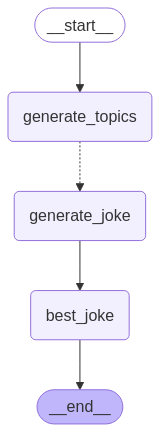

In [10]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [12]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['animals']}}
{'generate_joke': {'jokes': ["Why don't scientists trust atoms? Because they make up everything!"]}}
{'best_joke': {'best_selected_joke': "Why don't scientists trust atoms? Because they make up everything!"}}
